# Iterated CPR with Agents

Exploring some of the ideas in Ostrom's book Governing the Commons.

The plan is to explore how agent's time preferences might make them defect for a payout now and a punishment later in an iterated game. The goal is to better understand the constraints of the system and under which contexts a stable equilibrium might arrise to sustain the CPR and it's community.

It's interesting to note how most IRL systems have a delay between cause and effect, whereas digital systems can enforce rules immediately and deterministically. In the former there is much more room for behavioral economics and agent based modeling, whereas the later removes time preferences because rewards and punishments happen immediately.

It should also be noted that here a CPR implies a renewable resource, a set of actors who share in the appropriation (usage) of that resource, and a set of rules agreed upon by actors before they start appropriating said resource. In this context if an agent deviates from the agreed upon plan of action they are defecting.

There are also a large class of similar games in which the resource is non-renewable, there are no clear rules as to how to share the resource, or the appropriators were not included in the decision making process of said rules. In these cases it would be inappropriate to label the action set of actors as "cooperation" or "defection" without a scare and shared resource, a clear set of actions available, and an agreement between all parties involved as to which actions are valid and under which contexts.

## Check cadCAD

This cell doesn't do anything, but it does ensure that you know what version of cadCAD you're running. That way if/when you encounter technical difficulties you can tell the community which version of cadCAD you're running. Might save you hours of pain if all you need to do is upgrade to the latest version. 

In [883]:
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /usr/local/lib/python3.8/site-packages
Requires: pathos, fn, pandas, funcy
Required-by: cadCAD-diagram
Note: you may need to restart the kernel to use updated packages.


## Import Stuff

These are the libraries you'll need (cadCAD stuff) and that could be useful (python stuff) for your cadCAD model.

We're using [cadCAD Diagram](https://github.com/cadCAD-org/cadCAD_diagram), which is separate from cadCAD. If you're using the VS Code container from this repo it's already installed, but otherwise you might need to instal it.

In [884]:
# Python
import numpy as np
import random as random

# cadCAD
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor
from cadCAD_diagram import diagram_from_config

# Notebook setup
experiment = Experiment()
del configs[:]

## Initial Params

These are the parameters that control the behavior of a system. For example, if you were modeling a Web3 protocol these would be the parameters within a system that token holders could vote to modify. All of the parameters of a protocol that can be modified should be accessible here. That way it's easy to modify and run similations to explore how parameter changes might affect the network.

In [885]:
# The initial state of the system
genesis_states = {
    # Agents
    'agents': {
        i: {
            # payouts received by an agent
            'payouts': 0
        # number of agents in the system
        } for i in range(10)
    },
    # Common pool resource units
    'cpr': 100,
    # Number of cooperations
    'cooperations': 0,
    # Number of defections
    'defections': 0
}

# The parameters to run the model
params = {
    # Params within the system
    'M': {
        'cpr_respawn_rate': [10],
        'payout_cooperate': [1],
        'payout_defect': [5],
        'punishment_defect': [10],
        'monitoring_rate': [0.5]
    },
    # Timesteps per run
    'T': range(10),
    # Number of parallel runs
    'N': 1
}

## Policy Functions

Policy functions are like flows in stock and flow diagrams. They modify the inputs to state update functions.

In [886]:
# Policy to determine if agents cooperate or defect
def p_cord(params, step, sH, s):
    # Variables
    payout_cooperate = params['payout_cooperate']
    payout_defect = params['payout_defect']
    probable_defect_punishment = params['monitoring_rate'] * params['punishment_defect']
    cooperation = False
    # Logic
    if payout_cooperate >= payout_defect:
        cooperation = True
    elif payout_defect > probable_defect_punishment:
        cooperation = False
    else:
        cooperation = True
    # Output
    return ({'cooperation': cooperation})

# Policy to monitor agents
def p_monitor(params, step, sH, s):
    # Variables
    monitoring_rate = params['monitoring_rate']
    monitor_chance = random.uniform(0, 1)
    is_monitoring = False
    # Logic
    if monitor_chance >= monitoring_rate:
        is_monitoring = True
    # Output
    return ({'is_monitoring': is_monitoring})

# Respawn the CPR
def p_respawn(params, step, sH, s):
    # Variables
    cpr_respawn_rate = params['cpr_respawn_rate']
    # Logic
    # CPR is boosted at the respawn rate
    # In the future it might be more complicated
    cpr_boost = cpr_respawn_rate
    # Output
    return ({'cpr_boost': cpr_boost})

## State Update Functions

These functions take in inputs (state variables and policies) and modify the state.

In [887]:
# Log the if players cooperated this round
def s_log_cooperation(params, step, sH, s, _input):
    # Variables
    y = 'cooperations'
    x = s[y]
    cooperation = _input['cooperation']
    # Logic
    if cooperation:
        x += 1
    # Output
    return (y, x)

# Log the if players defected this round
def s_log_defection(params, step, sH, s, _input):
    # Variables
    y = 'defections'
    x = s[y]
    cooperation = _input['cooperation']
    # Logic
    if not cooperation:
        x += 1
    # Output
    return (y, x)

# Appropriate the CPR based on the appropriation policy
def s_appropriate(params, step, sH, s, _input):
    # Variables
    y = 'cpr'
    x = s[y]
    num_players = len(s['agents'])
    cooperation = _input['cooperation']
    payout = 0
    # Logic
    if cooperation:
        payout = params['payout_cooperate']
    elif not cooperation:
        payout = params['payout_defect']
    appropriation = num_players * payout
    x -= appropriation
    # Output
    return (y, x)

# Testing updating the state of agents
def s_payout(params, step, sH, s, _input):
    # Variables
    y = 'agents'
    x = s[y]
    payout_cooperate = params['payout_cooperate']
    payout_defect = params['payout_defect']
    cooperation = _input['cooperation']
    # Logic
    for i in x:
        if cooperation:
            x[i]['payouts'] += payout_cooperate
        else:
            x[i]['payouts'] += payout_defect
    # Output
    return (y, x)

# Policy to monitor and punish defections
def s_punish(params, step, sH, s, _input):
    # Variables
    y = 'agents'
    x = s[y]
    fine = params['punishment_defect']
    cooperation = _input['cooperation']
    is_monitoring = _input['is_monitoring']
    # Logic
    for i in x:
        if is_monitoring and not cooperation: 
            x[i]['payouts'] -= fine
    # Output
    return (y, x)

# Respawn the CPR based on the respawn policy
def s_respawn(params, step, sH, s, _input):
    # Variables
    y = 'cpr'
    x = s[y]
    # Logic
    cpr_boost = _input['cpr_boost']
    x += cpr_boost
    # Output
    return (y, x)

## State Update Block

If you're approaching cadCAD from Web3 you can think of the state of the model as something that evolves in blocks. Each block has a set of actions that updates the state. Those transactions then get batched into blocks to be processed together. In cadCAD blocks are called "`partial_state_update_blocks`." As you can see below, this is an array that is very similar to a "block" in a blockchain in that it represents a set of actions to update the state. That state is then updated across many timesteps. This is similar to how the state of a blockchain is updated over many timesteps as new blocks are added.



In [888]:
partial_state_update_blocks = [
    {
        'label': 'Appropriate',
        'policies': { 
            'cooperation': p_cord,
            'is_monitoring': p_monitor
        },
        'variables': {
            'cooperations': s_log_cooperation,
            'defections': s_log_defection,
            'cpr': s_appropriate,
            'agents': s_payout,
            'agents': s_punish,
            'agents': s_test
        }
    },
    {
        'label': 'Respawn',
        'policies': {
            'cpr_boost': p_respawn
        },
        'variables': {
            'cpr': s_respawn
        }
    }
]

## Running the cadCAD Engine

In [889]:
experiment.append_configs(
    initial_state = genesis_states,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = config_sim(params)
)

exec_mode = ExecutionMode()
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs) 
raw_system_events, tensor_field, sessions = simulation.execute() 


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 5, 1, 4)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.01s


## Data Visualization

This is often half the battle. Not only do need to design and build a cadCAD model, but you need to understand how it's working and be able to effectively communicate that to other people. A picture says a thousand words, thus enter data viz. Getting good at using python data viz libraries is probably the highest leverage thing you can do after you learn the cadCAD basics.

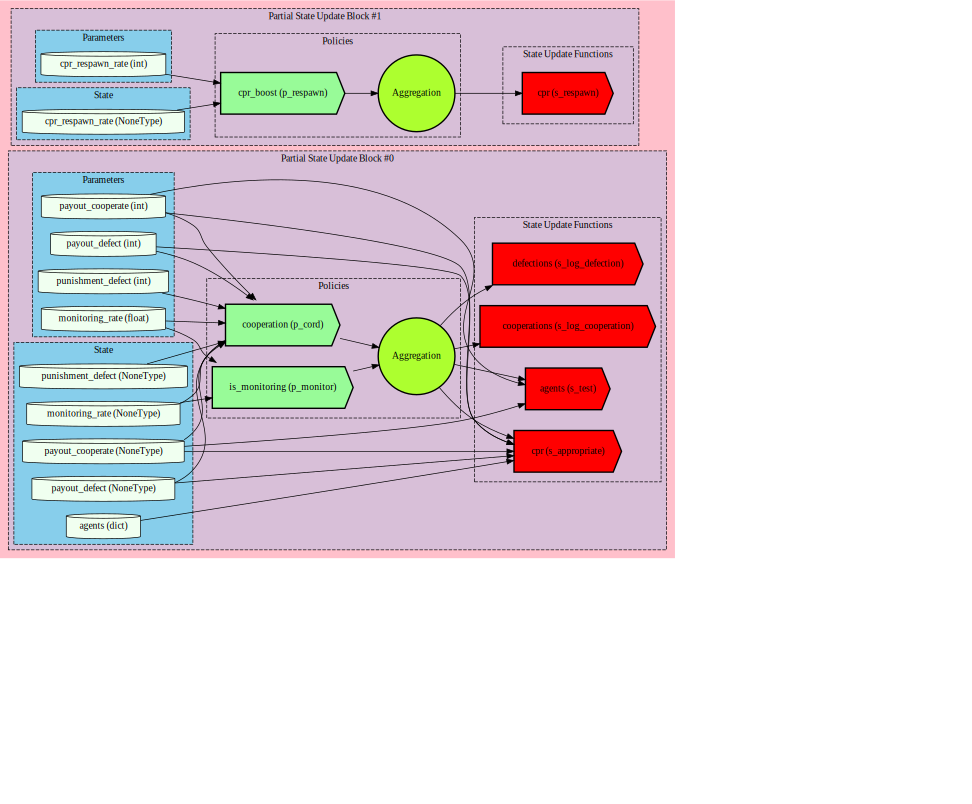

In [890]:
diagram_from_config(configs[0])

In [891]:
import pandas as pd
simulation_result = pd.DataFrame(raw_system_events)
simulation_result.set_index(['subset', 'run', 'timestep', 'substep'])

agents  \
subset run timestep substep                                                      
0      1   0        0        {0: {'payouts': 0}, 1: {'payouts': 0}, 2: {'pa...   
           1        1        {0: {'payouts': 1}, 1: {'payouts': 1}, 2: {'pa...   
                    2        {0: {'payouts': 1}, 1: {'payouts': 1}, 2: {'pa...   
           2        1        {0: {'payouts': 2}, 1: {'payouts': 2}, 2: {'pa...   
                    2        {0: {'payouts': 2}, 1: {'payouts': 2}, 2: {'pa...   
           3        1        {0: {'payouts': 3}, 1: {'payouts': 3}, 2: {'pa...   
                    2        {0: {'payouts': 3}, 1: {'payouts': 3}, 2: {'pa...   
           4        1        {0: {'payouts': 4}, 1: {'payouts': 4}, 2: {'pa...   
                    2        {0: {'payouts': 4}, 1: {'payouts': 4}, 2: {'pa...   
           5        1        {0: {'payouts': 5}, 1: {'payouts': 5}, 2: {'pa...   
                    2        {0: {'payouts': 5}, 1: {'payouts': 5}, 2: {'pa...   
           6        1        {0: {'payouts': 6}, 1: {'payouts': 6}, 2: {'pa...   
                    2        {0: {'payouts': 6}, 1: {'payouts': 6}, 2: {'pa...   
           7        1        {0: {'payouts': 7}, 1: {'payouts': 7}, 2: {'pa...   
                    2        {0: {'payouts': 7}, 1: {'payouts': 7}, 2: {'pa...   
           8        1        {0: {'payouts': 8}, 1: {'payouts': 8}, 2: {'pa...   
                    2        {0: {'payouts': 8}, 1: {'payouts': 8}, 2: {'pa...   
           9        1        {0: {'payouts': 9}, 1: {'payouts': 9}, 2: {'pa...   
                    2        {0: {'payouts': 9}, 1: {'payouts': 9}, 2: {'pa...   
           10       1        {0: {'payouts': 10}, 1: {'payouts': 10}, 2: {'...   
                    2        {0: {'payouts': 10}, 1: {'payouts': 10}, 2: {'...   

                             cpr  cooperations  defections  simulation  
subset run timestep substep                                             
0      1   0        0        100             0           0           0  
           1        1         90             1           0           0  
                    2        100             1           0           0  
           2        1         90             2           0           0  
                    2        100             2           0           0  
           3        1         90             3           0           0  
                    2        100             3           0           0  
           4        1         90             4           0           0  
                    2        100             4           0           0  
           5        1         90             5           0           0  
                    2        100             5           0           0  
           6        1         90             6           0           0  
                    2        100             6           0           0  
           7        1         90             7           0           0  
                    2        100             7           0           0  
           8        1         90             8           0           0  
                    2        100             8           0           0  
           9        1         90             9           0           0  
                    2        100             9           0           0  
           10       1         90            10           0           0  
                    2        100            10           0           0

<AxesSubplot:xlabel='timestep'>

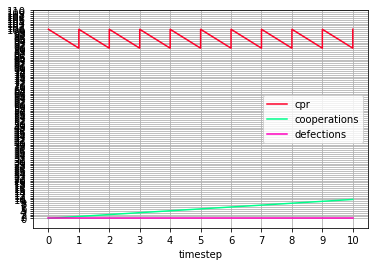

In [892]:
simulation_result.plot('timestep', ['cpr', 'cooperations', 'defections'], grid=True, 
        colormap = 'gist_rainbow',
        xticks=list(simulation_result['timestep'].drop_duplicates()), 
        yticks=list(range(1+(simulation_result['cpr']+simulation_result['cooperations']+simulation_result['defections']).max())))